## Prototyping our solution

This file serves as a prototype for the core logic of our system, designed to process uploaded videos by breaking them down into individual frames. For each frame, it applies a machine learning model to detect specific elements or patterns. The results of these will then be systematically recorded in a database.

## YoLo v9

In [1]:
from PIL import Image

In [2]:
import pandas as pd
from ultralytics import YOLO
import cv2

model = YOLO("yolov9c.pt")

# Display model information (optional)
model.info()

YOLOv9c summary: 618 layers, 25590912 parameters, 0 gradients, 104.0 GFLOPs


(618, 25590912, 0, 104.02268160000003)

In [3]:
import torch
if torch.cuda.is_available():
    model = model.to('cuda')

In [4]:
img = Image.open("images/poatan.png")

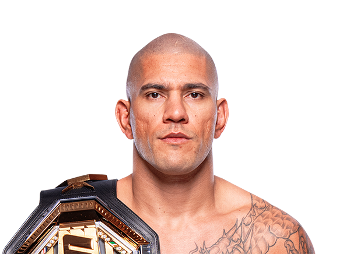

In [5]:
img

In [6]:
results = model.predict([img])


0: 480x640 1 person, 1281.0ms
Speed: 6.2ms preprocess, 1281.0ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
img.shape

In [6]:
type(results)

list

In [7]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [8]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.9443])
data: tensor([[  4.7216,  32.9692, 314.8803, 250.3686,   0.9443,   0.0000]])
id: None
is_track: False
orig_shape: (254, 350)
shape: torch.Size([1, 6])
xywh: tensor([[159.8010, 141.6689, 310.1586, 217.3994]])
xywhn: tensor([[0.4566, 0.5578, 0.8862, 0.8559]])
xyxy: tensor([[  4.7216,  32.9692, 314.8803, 250.3686]])
xyxyn: tensor([[0.0135, 0.1298, 0.8997, 0.9857]])

In [9]:
import json
detections_per_frame = [json.loads(result.tojson()) for result in results]

In [10]:
detections_per_frame

[[{'name': 'person',
   'class': 0,
   'confidence': 0.9443,
   'box': {'x1': 4.72164, 'y1': 32.96918, 'x2': 314.88028, 'y2': 250.36861}}]]

In [11]:
results[0].show()

In [12]:
results?

Type:        list
String form:
[ultralytics.engine.results.Results object with attributes:
           
           boxes: ultralytics.engine.results.Bo <...> eprocess': 7.043123245239258, 'inference': 1357.1577072143555, 'postprocess': 7.312774658203125}]
Length:      1
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

## Video to frames for processing

To facilitate the application of our machine learning model on video data, it is essential to decompose the video into individual frames. This process will enable us to apply the model to each frame independently, allowing for a comprehensive analysis of the video content frame by frame.

In [13]:
import cv2

In [14]:
def video_to_frames(video_path: str) -> list:
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    frames = []
    while success:
        frames.append(image)
        success,image = vidcap.read()
        count += 1
    
    print(f"read {count} frames")
    
    return frames

In [15]:
frames = video_to_frames("videos/psa.mp4")

read 221 frames


In [16]:
def object_detection(model, frames: list) -> list:
    return [json.loads(pred.tojson()) for pred in model.predict(frames, stream=True)]

In [17]:
results = object_detection(model, frames[:10])


0: 384x640 6 persons, 1238.7ms
1: 384x640 5 persons, 1238.7ms
2: 384x640 5 persons, 1238.7ms
3: 384x640 5 persons, 1 tennis racket, 1238.7ms
4: 384x640 6 persons, 1 tennis racket, 1238.7ms
5: 384x640 6 persons, 1 tennis racket, 1238.7ms
6: 384x640 5 persons, 1 tennis racket, 1238.7ms
7: 384x640 5 persons, 1 tennis racket, 1238.7ms
8: 384x640 5 persons, 1 tennis racket, 1238.7ms
9: 384x640 6 persons, 1 tennis racket, 1238.7ms
Speed: 4.1ms preprocess, 1238.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


In [19]:
results[0]

[{'name': 'person',
  'class': 0,
  'confidence': 0.8936,
  'box': {'x1': 339.13159, 'y1': 178.29608, 'x2': 406.24927, 'y2': 293.26645}},
 {'name': 'person',
  'class': 0,
  'confidence': 0.75274,
  'box': {'x1': 262.92075, 'y1': 178.14142, 'x2': 311.14877, 'y2': 284.25864}},
 {'name': 'person',
  'class': 0,
  'confidence': 0.54797,
  'box': {'x1': 536.3902, 'y1': 321.93524, 'x2': 586.60834, 'y2': 359.64496}},
 {'name': 'person',
  'class': 0,
  'confidence': 0.29651,
  'box': {'x1': 514.82983, 'y1': 324.96423, 'x2': 542.73779, 'y2': 359.73511}},
 {'name': 'person',
  'class': 0,
  'confidence': 0.27884,
  'box': {'x1': 324.6756, 'y1': 330.83917, 'x2': 375.24664, 'y2': 359.6037}},
 {'name': 'person',
  'class': 0,
  'confidence': 0.27177,
  'box': {'x1': 196.8663, 'y1': 323.54712, 'x2': 233.34412, 'y2': 359.7442}}]

### End to end test

In [20]:
def video_to_detections(video_path: str, model) -> list:
    frames = video_to_frames(video_path)
    return object_detection(model, frames)

In [21]:
entire_video_detections = video_to_detections("videos/psa.mp4", model)

read 221 frames

0: 384x640 6 persons, 1817.2ms
1: 384x640 5 persons, 1817.2ms
2: 384x640 5 persons, 1817.2ms
3: 384x640 5 persons, 1 tennis racket, 1817.2ms
4: 384x640 6 persons, 1 tennis racket, 1817.2ms
5: 384x640 6 persons, 1 tennis racket, 1817.2ms
6: 384x640 5 persons, 1 tennis racket, 1817.2ms
7: 384x640 5 persons, 1 tennis racket, 1817.2ms
8: 384x640 5 persons, 1 tennis racket, 1817.2ms
9: 384x640 6 persons, 1 tennis racket, 1817.2ms
10: 384x640 5 persons, 1817.2ms
11: 384x640 5 persons, 1817.2ms
12: 384x640 5 persons, 1817.2ms
13: 384x640 5 persons, 1817.2ms
14: 384x640 6 persons, 1817.2ms
15: 384x640 6 persons, 1817.2ms
16: 384x640 5 persons, 1817.2ms
17: 384x640 5 persons, 1817.2ms
18: 384x640 4 persons, 1 tennis racket, 1817.2ms
19: 384x640 5 persons, 1 tennis racket, 1817.2ms
20: 384x640 4 persons, 1817.2ms
21: 384x640 4 persons, 1817.2ms
22: 384x640 4 persons, 1817.2ms
23: 384x640 4 persons, 1817.2ms
24: 384x640 5 persons, 1817.2ms
25: 384x640 5 persons, 1817.2ms
26: 384x